# THE BATTLE OF NEIGHBORHOODS #

## Introduction: ##

New York City''s demographics show that it is a large and ethnically diverse metropolis. With it''s diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great indian resturants.

## Data: ##

For this project we need the following data:

1.New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.

2.Indian resturants in each neighborhood of new york city.

3.GeoSpace data.

## Questions that will be answers at the end of this project : ##

1. What are best location in New York City for Indian Cuisine?

2. Which areas have potential Indian Restaurant Market?

3. Which all areas lack Indian Restaurants?

4. Which is the best place to stay if you prefer Indian Cuisine?

## Methodology: ##

1.We begin by collecting the New York city data from "https://cocl.us/new_york_dataset".

2.We will find all venues for each neighborhood using FourSquare API.

3.We will then filter out all Indian Restuarant venues.

4.Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Indian Resturants.

5.Next we will sort the data keeping Ratings as the constraint.

6.Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

Lets Start by importing the required Libraries.

In [1]:
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle requests
import requests
print('requests imported...')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')

# import k-means from clustering stage
from sklearn.cluster import KMeans

numpy, pandas, ..., imported...
geopy installed...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'M2FADHYKHUVXA3TA0KNI00A4F4YVOCE0IDVBWWD2K4AG55Q2' # your Foursquare ID
    CLIENT_SECRET = '4ZQT0D5HSGSDETBHMBZ1YOEMHKRVZFVEBFYTWRD02BVSLZHR' # your Foursquare Secret
    VERSION = '20180604' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [4]:
def get_venue_details(venue_id):
        
     CLIENT_ID = 'M2FADHYKHUVXA3TA0KNI00A4F4YVOCE0IDVBWWD2K4AG55Q2' # your Foursquare ID
     CLIENT_SECRET = '4ZQT0D5HSGSDETBHMBZ1YOEMHKRVZFVEBFYTWRD02BVSLZHR' # your Foursquare Secret
     VERSION = '20180604' # Foursquare API version
    
     #url to fetch data from foursquare api
     url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
             venue_id,
             CLIENT_ID, 
             CLIENT_SECRET, 
             VERSION)
    
     # get all the data
     results = requests.get(url).json()
     venue_data=results['response']['venue']
     venue_details=[]
     try:
         venue_id=venue_data['id']
         venue_name=venue_data['name']
         venue_likes=venue_data['likes']['count']
         venue_rating=venue_data['rating']
         venue_tips=venue_data['tips']['count']
         venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
     except KeyError:
         pass
        
     column_names=['ID','Name','Likes','Rating','Tips']
     df = pd.DataFrame(venue_details,columns=column_names)
     return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
url='https://cocl.us/new_york_dataset'
resp=requests.get(url).json()
    # all data is present in features label
features=resp['features']
    
    # define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
new_york_data = pd.DataFrame(columns=column_names)
    
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

We will call the above funtion to get the new york city data.

In [6]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
new_york_data.shape

(306, 4)

## The above result shows that there are 306 different Neighborhoods in New York. ##

Now let create a BAR PLOT to show different Neighborhoods in New York.

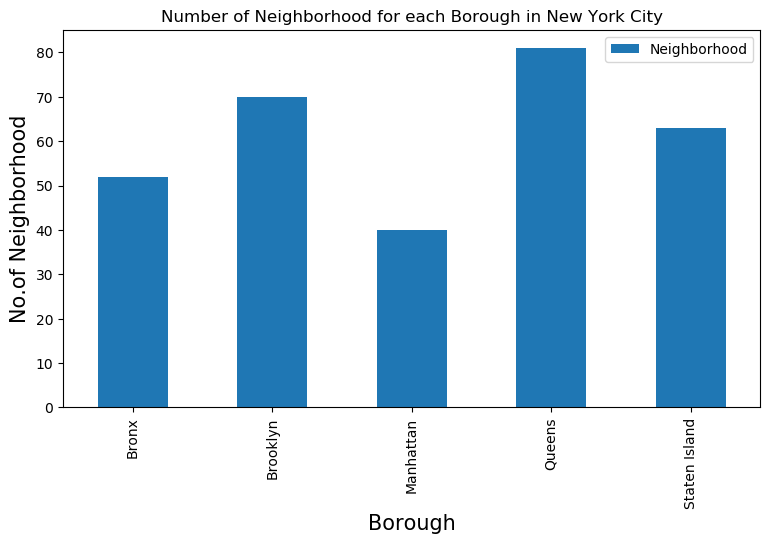

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude, Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [18]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Williamsbridge,570c3a3fcd10eecd0d0434cd,Agra Grill
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [21]:
indian_rest_ny.shape

(33, 4)

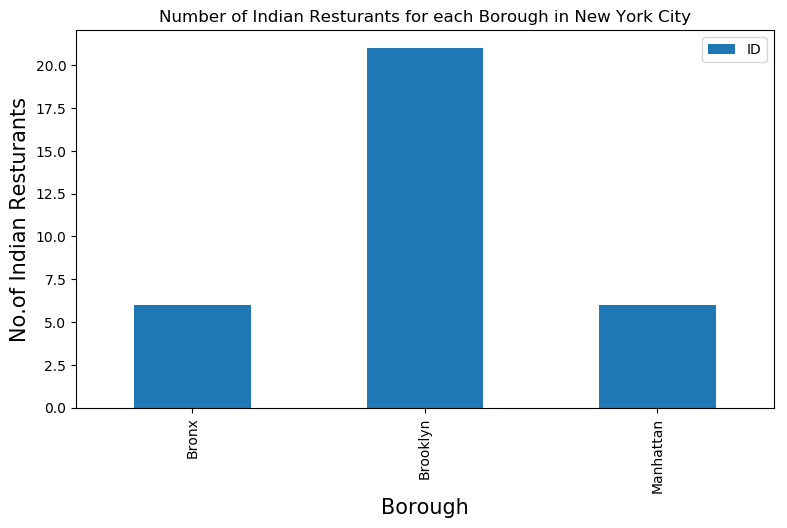

In [22]:
%matplotlib inline
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

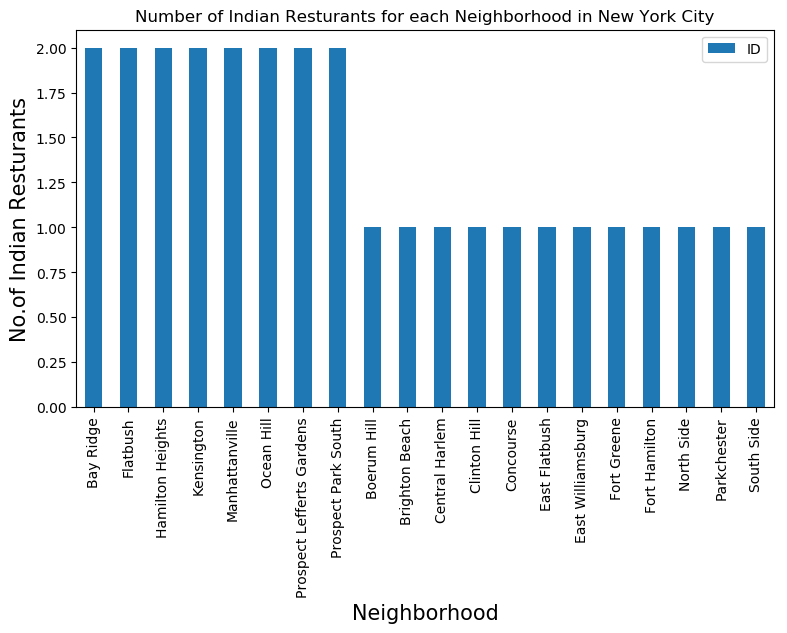

In [23]:
%matplotlib inline
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(20).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [25]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name


In [26]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        #print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    #print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 570c3a3fcd10eecd0d0434cd


In [27]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Williamsbridge,0,0,0,0.0,0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.0,3


In [28]:
indian_rest_stats_ny.shape

(33, 7)

In [29]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              57596dad498e732300496b23
Name                         Dosa Royale
Likes                                 78
Rating                               8.8
Tips                                  22
Name: 14, dtype: object

In [30]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [31]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
4,Clinton Hill,8.80
9,Fort Greene,8.80
3,Central Harlem,8.60
6,East Flatbush,8.40
19,South Side,8.30
14,North Side,8.30
15,Ocean Hill,8.05
1,Boerum Hill,8.00
22,Washington Heights,8.00
0,Bay Ridge,7.95


In [32]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [33]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,7.819048
2,Manhattan,7.750000
0,Bronx,5.516667


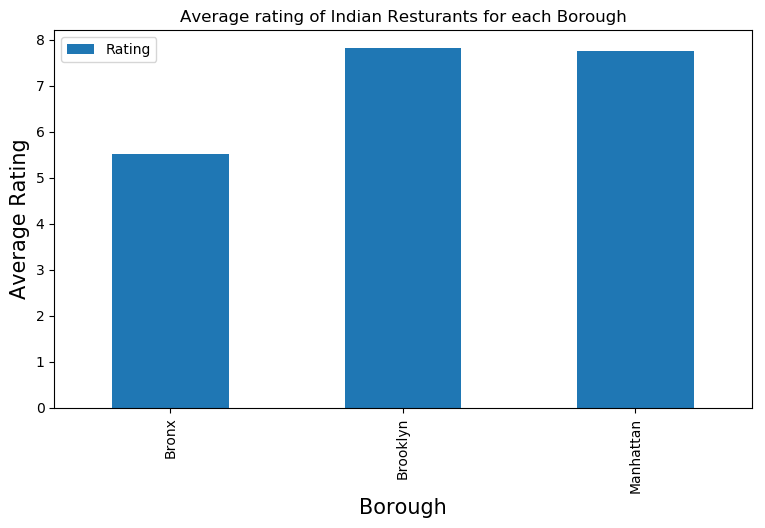

In [34]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [35]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [36]:
ny_neighborhood_stats.shape

(9, 2)

In [37]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [39]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,8.00
1,Manhattan,Central Harlem,40.815976,-73.943211,8.60
2,Brooklyn,Clinton Hill,40.693229,-73.967843,8.80
3,Brooklyn,East Flatbush,40.641718,-73.936103,8.40
4,Brooklyn,Fort Greene,40.688527,-73.972906,8.80
5,Brooklyn,North Side,40.714823,-73.958809,8.30
6,Brooklyn,Ocean Hill,40.678403,-73.913068,8.05
7,Brooklyn,South Side,40.710861,-73.958001,8.30
8,Manhattan,Washington Heights,40.851903,-73.936900,8.00


In [41]:
!pip install folium
import folium
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [42]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [43]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [44]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Conclusion : ##

### So now we can answer the questions asked above in the Questions section of the notebook. ###

### From our anaysis the answers to the above questions are: ###

#### A1) Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for Indian cuisine. ####

#### A2) Manhattan have potential Indian Resturant Market. ####

#### A3) Staten Island ranks last in average rating of Indian Resturants. ####

#### A4) Manhattan is the best place to stay if you prefer Indian Cuisine. ####